In [4]:
#Import Libs----
import pandas as pd
import transformers
import numpy as np
import datasets
import json
import torch
import json
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [5]:
# Created Pandas DataFrame --- (Small Chunck)
df = pd.read_csv('/kaggle/input/patent-match/test_balanced.tsv', sep="\t", usecols = ['text','text_b','label'])
df = df[(df['text'].str.len() < 200) & (df['text_b'].str.len() < 200)]
df.reset_index(inplace=True)
df = df[['text', 'text_b', 'label']]

# Split DataFrame
train = df[:1800]
test = df[1800:]

In [6]:
# Convert Pandas Frame to DatasetDict
train = Dataset.from_pandas(train)
test = Dataset.from_pandas(test)

In [7]:
# Save to jsonl
with open("train.jsonl", "w") as f:
    for item in train:
        f.write(json.dumps(item) + "\n")
with open("test.jsonl", "w") as f:
    for item in test:
        f.write(json.dumps(item) + "\n")

In [8]:
# Define Tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# # Checking Tokenizer
# encoded = tokenizer("What  of former students?", "science labs research at the university.", return_tensors="pt")
# decoded = tokenizer.decode(encoded["input_ids"][0])
# print(decoded)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
# Let's Tokenize the Whole Data.....
def preprocess_function(batch):
    return tokenizer(batch["text"], batch["text_b"], truncation=True, padding="max_length")

dataset = datasets.load_dataset("json", data_files={"train": "/kaggle/working/train.jsonl", "test": "/kaggle/working/test.jsonl"})
tokenized_data = dataset.map(preprocess_function, batched=True)
print(tokenized_data)                                             

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-47735df33c44e86b/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'text_b', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1800
    })
    test: Dataset({
        features: ['text', 'text_b', 'label', 'input_ids', 'attention_mask'],
        num_rows: 503
    })
})


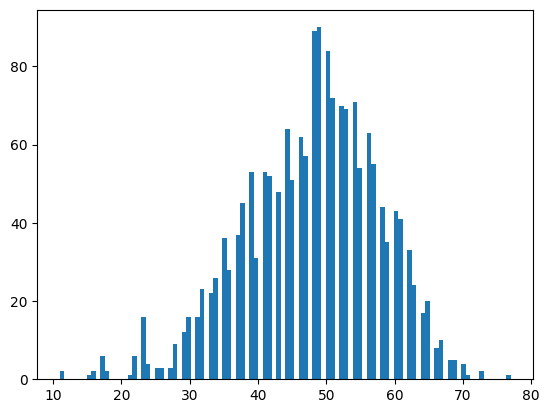

In [10]:
question_and_context = []

for item in dataset["train"]:
    question_and_context.append(item["text"] + " " + item["text_b"])

# Visualize the distribution of the length of the questions and contexts
import matplotlib.pyplot as plt
plt.hist([len(item.split()) for item in question_and_context], bins=100)
plt.show()

In [11]:
# Let's Define the Trainer Class for Training the model..... 
from transformers import Trainer, TrainingArguments
 
def compute_metrics(eval_pred):
    f1_score = datasets.load_metric("f1")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1_score.add_batch(predictions=predictions, references=labels)
    return f1_score.compute()
 
model = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
 
training_args = TrainingArguments(
    output_dir="/kaggle/working/",  # output directory
    num_train_epochs=3,  # total # of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=8,  # batch size for evaluation
    warmup_steps=50,  # number of warmup steps for learning rate scheduler
    weight_decay=0.01,  # strength of weight decay
    learning_rate=2e-5,  # learning rate
    save_total_limit=2,  # limit the total amount of checkpoints, delete the older checkpoints
    logging_dir="./logs",  # directory for storing logs
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
)
 
trainer = Trainer(
    model=model,  # the instantiated 🤗 Transformers model to be trained
    args=training_args,  # training arguments, defined above
    train_dataset=tokenized_data["train"],  # training dataset
    eval_dataset=tokenized_data["test"],  # evaluation dataset
    compute_metrics=compute_metrics,  # the callback that computes metrics of interest
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [12]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,F1
50,0.693500,0.692590,0.634014
100,0.706700,0.657891,0.673947
150,0.617400,0.588900,0.497041
200,0.529200,0.384441,0.811060
250,0.294500,0.334923,0.857732
300,0.308300,0.313979,0.866667
350,0.243300,0.302985,0.912206
400,0.258000,0.339067,0.900826
450,0.305500,0.231570,0.914163
500,0.136200,0.221153,0.932166


TrainOutput(global_step=675, training_loss=0.3345588366190592, metrics={'train_runtime': 528.3455, 'train_samples_per_second': 10.221, 'train_steps_per_second': 1.278, 'total_flos': 1420799698944000.0, 'train_loss': 0.3345588366190592, 'epoch': 3.0})

In [13]:
# Evalute
trainer.evaluate()

{'eval_loss': 0.23248712718486786,
 'eval_f1': 0.9455337690631809,
 'eval_runtime': 10.7156,
 'eval_samples_per_second': 46.941,
 'eval_steps_per_second': 5.879,
 'epoch': 3.0}

In [14]:
# Load The Model Checkpoints.......
model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/working/checkpoint-650", num_labels=2
).to('cuda')

In [28]:
# Let's Check One Example from Train Dataset......
from transformers import AutoTokenizer, AutoModelForSequenceClassification

x = train['text'][10]
y = train['text_b'][10]
y_True = train['label'][10]

tokenizer = AutoTokenizer.from_pretrained("roberta-base")
encoded = tokenizer(x, y, return_tensors="pt").to("cuda")
decoded = tokenizer.decode(encoded["input_ids"][0])

x = model(**encoded)
predictions = torch.argmax(x.logits, dim=1)
print(f'Prediction class : {predictions[0].item()}\nActual Class : {y_True}')

Prediction class : 1
Actual Class : 1


In [31]:
# Lets Check on the Test Dataset....
y_pred = []
y_actual = []
true = 0
wrong = 0
for i in range(500):
    x = test['text'][i]
    y = test['text_b'][i]
    z = test['label'][i]
    encoded = tokenizer(x, y, return_tensors="pt").to("cuda")
    x = model(**encoded)
    predictions = torch.argmax(x.logits, dim=1)
    y_pred.append(predictions[0].item())
    y_actual.append(z)
    if predictions[0].item() == z:
        true += 1
    else:
        wrong += 1
print(f'True Prediction : {true}: Wrong Prediction {wrong}' )

True Prediction : 474: Wrong Prediction 26


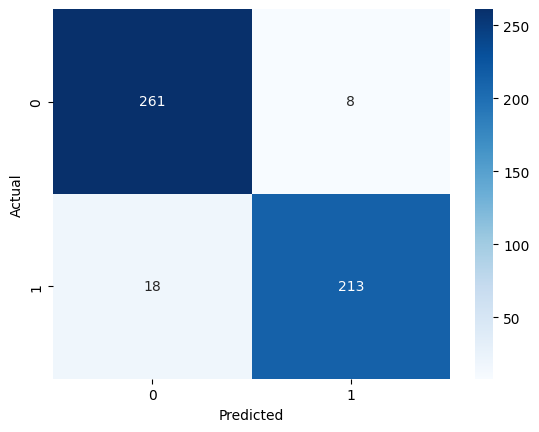

In [32]:
# generate confusion matrix
cm = confusion_matrix(y_true=y_actual, y_pred=y_pred)

# plot confusion matrix using seaborn heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()